## Imports

### Install packages

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

### Import modules

In [2]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux ec1347f4acf5 6.10.14-linuxkit #1 SMP Tue Apr 15 16:00:54 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.3
arviz version=0.21.0
preliz version=0.19.0


# Posterior predictive check: Examples

In [4]:
dir_name = "./Lesson07-data"

!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1.081000,-0.888000,-0.623000,-0.4800,-0.505000,-0.345000,0.052000,0.061000,0.215000,0.395000,...,2.531000,2.765000,2.913000,3.168000,3.119000,3.385000,3.488000,3.538000,3.90,3.9700
1,1.168561,0.788544,0.388129,0.2304,0.255025,0.119025,0.002704,0.003721,0.046225,0.156025,...,6.405961,7.645225,8.485569,10.036224,9.728161,11.458225,12.166144,12.517444,15.21,15.7609


FileNotFoundError: [Errno 2] No such file or directory: '/app/lectures_source/figures/Lesson07.Comparing_models.data.png'

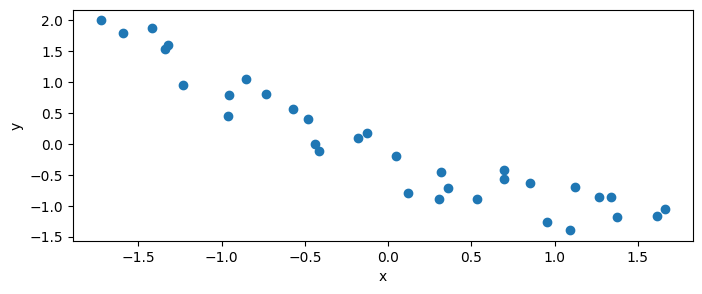

In [5]:
# Load some data it's mainly a linear relationship with some data.
dummy_data = np.loadtxt(dir_name + '/dummy.csv')
x = dummy_data[:, 0]
y = dummy_data[:, 1]

# Transform the data applying various powers and stacking the data, so that
# we have different rows with different predicted variables.
order = 2
x_p = np.vstack([x**i for i in range(1, order + 1)])
display(pd.DataFrame(x_p))

# Normalize all the data.
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()

# Plot the 0-order data (i.e., the original one).
plt.scatter(x_c[0], y_c)
plt.xlabel('x')
plt.ylabel('y');

ut.save_plt("Lesson07.Comparing_models.data.png")

In [ ]:
# Linear model.
with pm.Model() as model_l:
    # mu = alpha + beta * x
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=10)
    mu = alpha + beta * x_c[0]
    #
    sigma = pm.HalfNormal('sigma', 5)
    #
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_c)
    #
    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))
    

# Quadratic model.
with pm.Model() as model_p:
    # mu = alpha + beta_1 * x + beta_2 * x^2
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    # Beta is a 2-dim vector.
    beta = pm.Normal('beta', mu=0, sigma=10, shape=order)
    mu = alpha + pm.math.dot(beta, x_c)
    #
    sigma = pm.HalfNormal('sigma', 5)
    #
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_c)
    #
    idata_q = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_q.extend(pm.sample_posterior_predictive(idata_q))

In [ ]:
#
# Plot the data and the fit linear and quadratic models (using the mean posterior).
#

# Sample the x space uniformly with 100 samples.
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

# Posterior.
posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_q)
#print(posterior_l)

# Compute the mean posterior of the linear model.
alpha_l_post = posterior_l["alpha"].mean().item()
beta_l_post = posterior_l["beta"].mean().item()
print(f"linear model: alpha_l_post={alpha_l_post:.2g}, beta_l_post={beta_l_post:.2g}")
y_l_post = alpha_l_post + beta_l_post * x_new

# Plot the mean posterior of the linear model.
plt.plot(x_new, y_l_post, "C0", label="linear model")

# Quadratic model.
alpha_p_post = posterior_p["alpha"].mean().item()
beta_p_post = posterior_p["beta"].mean("sample")
print(f"quadratic model: alpha_p_post={alpha_p_post:.2g}, beta_post[0]={beta_p_post[0]:.2g}, beta_post[1]={beta_p_post[1]:.2g}")
y_p_post = alpha_p_post + np.dot(beta_p_post, x_c)

#idx = np.argsort(x_c[0])
#plt.plot(x_c[0][idx], y_p_post[idx], "C1", label="quadratic model")
plt.plot(x_c[0], y_p_post, "C1", label="quadratic model")

# Plot data.
plt.plot(x_c[0], y_c, "C2.");

ut.save_plt("Lesson07.Comparing_models.model_fit.png")

In [ ]:
#
# Plot the posterior predictive check for both models.
#

az.plot_ppc(idata_l, num_pp_samples=100, colors=["C1", "C0", "C1"])
plt.title("linear model");
ut.save_plt("Lesson07.Comparing_models.lin_model_PPC.png")

az.plot_ppc(idata_q, num_pp_samples=100, colors=["C1", "C0", "C1"])
plt.title("quadratic model");
ut.save_plt("Lesson07.Comparing_models.quadr_model_PPC.png")

In [ ]:
#?az.plot_bpv

## Bayesian p-value

In [ ]:
#
# Compare the Bayesian p-value for a statistic for linear and quadratic model.
#

colors = ["C0", "C1"]
idatas = [idata_l, idata_q]

fig, axes = plt.subplots(2, 1)

# Plot the Bayesian p-value for mean for both models.
for idata, c in zip(idatas, colors):
    # Plot Bayesian p-value.
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)
    axes[0].set_title("linear")

# Plot the Bayesian p-value for interquartile range for both models.
def iqr(x, a=-1):
    """
    Interquartile range.
    """
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idata, c in zip(idatas, colors):
    # Plot Bayesian p-value.
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

In [ ]:
#
# Compare Bayesian p-value for entire distribution.
#

fig, ax = plt.subplots()

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

# Overfitting

In [ ]:
_, ax = plt.subplots(1, 1)

x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])
x1 = np.array([6.5, 10])
y1 = np.array([7, 10])

ax.plot(x0, y0, "ko");
ax.plot(x1, y1, "rs");

In [ ]:
#
# Fit model on in-sample data.
#
_, ax = plt.subplots(1, 1)

# Data.
x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])
ax.plot(x0, y0, "ko", zorder=3)

# Learn 3 models.
order = [0, 1, 5]
x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    # Learn the models.
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)

# 
def plot_models(x0, y0, ps):
    for i in range(len(order)):
        p = ps[i]
        # Evaluate on the raw data.
        yhat = p(x0)
        # Estimate the error between the estimates and the true values.
        ss_regression = np.sum((yhat - y0) ** 2)
        # Compute R^2.
        ybar = np.mean(y0)
        ss_total = np.sum((ybar - y0) ** 2)
        r2 = 1 - ss_regression / ss_total
        #
        ax.plot(x_n, p(x_n), label=f"order {i}, $R^2$= {r2:.3f}", lw=3)
    ax.legend(loc=2)


plot_models(x0, y0, ps)

In [ ]:
#
# Evaluate the fit model on the out-of-sample data.
#
_, ax = plt.subplots(figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, "ko", zorder=3)
ax.plot(x_, y_, "rs", zorder=3)

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

plot_models(x1, y1, ps)

## Calculating predictive accuracy

In [ ]:
waic_l = az.waic(idata_l)
waic_l

In [ ]:
waic_q = az.waic(idata_q)
waic_q

In [ ]:
loo_l = az.loo(idata_l)
loo_l

In [ ]:
loo_q = az.loo(idata_q)
loo_q

## Comparing models

In [ ]:
cmp_df = az.compare({
    "model_l": idata_l,
    "model_q": idata_q})
display(cmp_df)

In [ ]:
az.plot_compare(cmp_df);

## Model averaging

In [ ]:
idatas = [idata_l, idata_q]
weights = [0.35, 0.65]
idata_w = az.weight_predictions(idatas, weights)

In [ ]:
# Plot the KDE of the posterior predictive.
_, ax = plt.subplots(figsize=(10, 6))

# Linear.
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)

# Quadratic.
az.plot_kde(
    idata_q.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="quadratic",
    ax=ax,
)

# Weighted.
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.legend();